In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("groq_api")
os.environ["TAVILY_API_KEY"] = os.getenv("tavily_api")

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")

In [3]:
arxiv.invoke("attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query wikipedia articles")

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/06/qptk6bh16_ndqt8gkn0559p00000gq/T/ipykernel_41990/735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [6]:
tavily.invoke("What is the weather of taipei today")

[{'title': 'Weather for Taipei City, Taiwan - Time and Date',
  'url': 'https://www.timeanddate.com/weather/@1668338',
  'content': 'timeanddate.com\nFlag for Taiwan\n\n# Weather in Taipei City, Taiwan\n\nScattered clouds.\n\nFeels Like: 75 °F  \nForecast: 59 / 46 °F  \nWind: 13 mph ↑ from Northwest\n\n|  |  |\n --- |\n| Location: | Sungshan / Taipei |\n| Current Time: | Jan 5, 2026 at 2:38:06 pm |\n| Latest Report: | Jan 5, 2026 at 2:00 pm |\n| Visibility: | N/A |\n| Pressure: | 30.09 "Hg |\n| Humidity: | 65% |\n| Dew Point: | 59 °F |\n\nLocation of Taipei City\nLocation\n\n## Upcoming 5 hours [...] | Amount of Snow | 0.00" | 0.00" | 0.00" | 0.00" | 0.00" | 0.00" | 0.00" |\n|  |  |  |  |  |  |  |  |\n ---  ---  ---  --- |\n| \\ Updated Monday, January 5, 2026 9:42:39 am Taipei City time - Weather by CustomWeather, © 2026 | | | | | | | | [...] 72 / 61 °F\n\n72 / 61 °F\n\n72 / 61 °F\n\nDetailed forecast for 14 days\n\nNeed some help?\n\nIllustration of a pink shield with a white heart.\

In [7]:
tools = [arxiv, wiki, tavily]
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")

In [8]:
# initialize LLM model
llm.invoke("what is python")

AIMessage(content='<think>\nOkay, the user is asking "what is Python." Let me start by recalling what I know about Python. It\'s a programming language, but I should make sure I cover the key points.\n\nFirst, Python is high-level, which means it\'s easier to read and write compared to lower-level languages like C. It\'s interpreted, so code is executed line by line without needing to compile the entire program first. That\'s good for development speed.\n\nPython is known for its simplicity and readability. The syntax uses indentation for code blocks instead of braces or keywords, which is a big plus for beginners. I should mention that it\'s versatile—used in web development, data science, automation, machine learning, and more.\n\nObject-oriented programming is a feature, but Python also supports procedural and functional programming paradigms. It has a large standard library that includes modules for various tasks, which saves time. The community is active, so there are lots of thir

In [9]:
llm_with_tool = llm.bind_tools(tools)

In [10]:
llm_with_tool.invoke("what is the recent news on ai")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. Let me see which tool I should use here. The available tools are arxiv, wikipedia, and tavily_search_results_json.\n\nArxiv is for academic papers, so that\'s probably not the best choice here. Wikipedia might have some information, but it\'s more of a general knowledge source and might not have the latest news. The user specified "recent news," which suggests they want the latest updates. \n\nLooking at the description of tavily_search_results_json, it says it\'s optimized for comprehensive, accurate, and trusted results, especially for current events. That fits perfectly with the user\'s query. So I should use tavily_search_results_json with the query "recent news on AI." \n\nI need to make sure the parameters are correct. The required parameter is "query," and the type is string. The user\'s query is straightforward, so I can directly pass "recent news on ai" as the query a

# workflow

In [20]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # humain or machine message
from typing import Annotated # labelling
from langgraph.graph.message import add_messages # reducer in langgraph 
from langchain_core.messages.human import HumanMessage


In [13]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [18]:
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # if latest message from assistant is tool -> tool condition routes to tools
    # if latest message from assistant is not a tool call -> rout to llm
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()                        
                              

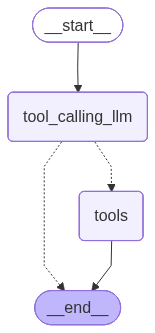

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages = graph.invoke({"messages": HumanMessage(content="1706.03762")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (cvr0r822z)
 Call ID: cvr0r822z
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [22]:
messages = graph.invoke({"messages": HumanMessage(content="hi my name is yuhsuan")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi my name is yuhsuan
================================== Ai Message ==================================

Hello Yuhsuan! It's nice to meet you. How can I assist you today?


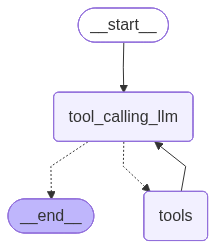

In [24]:
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # if latest message from assistant is tool -> tool condition routes to tools
    # if latest message from assistant is not a tool call -> rout to llm
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
# builder.add_edge("tool_calling_llm", END)

graph = builder.compile()                        
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
messages = graph.invoke({"messages": HumanMessage(content="what is the weather in taipei now and please tell me what is the latest llm research paper")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is the weather in taipei now and please tell me what is the latest llm research paper
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (3a1d7254e)
 Call ID: 3a1d7254e
  Args:
    query: current weather in taipei
  arxiv (gxek4dny8)
 Call ID: gxek4dny8
  Args:
    query: latest large language model research paper
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Taipei weather in May 2026 | Taiwan: How hot?", "url": "https://www.weather2travel.com/taiwan/taipei/may/", "content": "weather2travel.com - travel deals for your holiday in the sun\nClick to search\n\n# Taipei weather in May 2026\n\nExpect  daytime maximum temperatures of 27°C in Taipei, Taiwan in May based on long-term weather averages. There are 4 hours of sunshine per day on average with 21 d

In [28]:
messages

{'messages': [HumanMessage(content='what is the weather in taipei now and please tell me what is the latest llm research paper', additional_kwargs={}, response_metadata={}, id='c7dd05c2-e2e4-43b4-b861-26452532130e'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, let\'s tackle the user\'s query. They want two things: the current weather in Taipei and the latest LLM research paper.\n\nFirst, for the weather in Taipei, I need to use a search engine to get the most up-to-date information. The available tools include Tavily Search, which is good for current events. So I\'ll call Tavily Search with the query "current weather in Taipei".\n\nNext, the user is asking for the latest LLM research paper. The arXiv tool is suitable here because it\'s a repository for academic papers. I\'ll use arXiv with the query "latest large language model research paper" to find the most recent publications. \n\nI need to make sure both tools are called correctly. The parameters for bot